In [4]:
import ast
import pandas as pd 
import timeit
import numpy as np 
from statistics import mean
import prophet
import pydeck as pdk
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Imports

In [5]:
#Import two data-sets
starbucks_df = pd.read_csv('./Clean_Data/London_Starbucks_Data.csv')
airbnb_df = pd.read_csv('./Clean_Data/London_AirBNB_Data.csv')
#Convert List columns stored as strings to lists
starbucks_df['airbnb_distances'] = starbucks_df['airbnb_distances'].apply(ast.literal_eval)
airbnb_df['starbucks_distances'] = airbnb_df['starbucks_distances'].apply(ast.literal_eval)
#Convert Date columns to Datetime
airbnb_df['first_review'] = pd.to_datetime(airbnb_df['first_review'])
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
#Preview to verify
display(starbucks_df.head(1))
display(starbucks_df.info())

display(airbnb_df.head(1))
display(airbnb_df.info())

,store_id,index,countryCode,ownershipTypeCode,latitude,longitude,city,countrySubdivisionCode,postalCode,distance_to_den,airbnb_distances
0,17111,23030,GB,CO,51.609615,-0.643035,Beaconsfield,ENG,HP9 1,23.25,"[23.01, 22.13, 22.47, 22.83, 18.77, 25.39, 17...."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store_id                256 non-null    int64  
 1   index                   256 non-null    int64  
 2   countryCode             256 non-null    object 
 3   ownershipTypeCode       256 non-null    object 
 4   latitude                256 non-null    float64
 5   longitude               256 non-null    float64
 6   city                    256 non-null    object 
 7   countrySubdivisionCode  256 non-null    object 
 8   postalCode              255 non-null    object 
 9   distance_to_den         256 non-null    float64
 10  airbnb_distances        256 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 22.1+ KB


None

,id,description,neighborhood_overview,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,starbucks_distances,starbucks_review_mentions
0,13913,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,LB of Islington,Islington,51.56861,-0.1127,Private room in rental unit,Private room,1,...,4.72,4.74,4.82,4.69,4.69,f,2,0.26,"[23.01, 22.24, 22.23, 19.26, 19.84, 19.42, 15....",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87701 entries, 0 to 87700
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              87701 non-null  int64         
 1   description                     87701 non-null  object        
 2   neighborhood_overview           87701 non-null  object        
 3   host_neighbourhood              87701 non-null  object        
 4   neighbourhood_cleansed          87701 non-null  object        
 5   latitude                        87701 non-null  float64       
 6   longitude                       87701 non-null  float64       
 7   property_type                   87701 non-null  object        
 8   room_type                       87701 non-null  object        
 9   accommodates                    87701 non-null  int64         
 10  bathrooms_text                  87701 non-null  object        
 11  be

None

In [6]:
string = 'here is a string'
string[:string.find(' ')]

'here'

In [9]:
#Omitted Bathroom counting function from data cleaning notebook - too computationally intensive 
#to rerun, as such, implemented here.
def bathroom_count(row):
    string = row['bathrooms_text']
    string = string[:string.find(' ')]
    try:
        count = float(string)
    except: 
        count = 0
    return count
airbnb_df['bathroom_count'] = airbnb_df.apply(bathroom_count,axis=1)

In [ ]:
airbnb_df['bathroom_count'].value_counts()

# Data Analytics

In [ ]:
#Manually assigned distances of interest
bins = [.1, .25, .5, 1, 2, 5]
#Define a function that loops through each 'bin' (not technically correct)
#and counts starbucks within that range, then populate a column with that count
#for future plots
def airbnb_to_starbucks():
    for bin in bins:
        def nested_bin(row):
            dist_to_sb_list = row['starbucks_distances']
            sb_within_range = [x for x in dist_to_sb_list if x < bin]
            return len(sb_within_range)
        column_name = f"SB_within_{bin}_miles"
        airbnb_df[column_name] = airbnb_df.apply(nested_bin, axis=1)
# Run the function
airbnb_to_starbucks()
# Do it again for starbucks
def starbucks_to_airbnb():
    for bin in bins:
        def nested_bin(row):
            dist_to_bnb_list = row['airbnb_distances']
            bnb_within_range = [x for x in dist_to_bnb_list if x < bin]
            return len(bnb_within_range)
        column_name = f"Airbnb_within_{bin}_miles"
        starbucks_df[column_name] = starbucks_df.apply(nested_bin, axis=1)
starbucks_to_airbnb()

In [ ]:
#calculate the average distance to the nearest 5 starbucks or bnbs
def mean_dist_nearest_5_sb(row):
    dist_list = row['starbucks_distances']
    dist_list.sort()
    return round(mean(dist_list[:5]),2)

def mean_dist_nearest_5_bnb(row):
    dist_list = row['airbnb_distances']
    dist_list.sort()
    return round(mean(dist_list[:5]),2)

airbnb_df['nearest_5_avg'] = airbnb_df.apply(mean_dist_nearest_5_sb, axis=1)
starbucks_df['nearest_5_avg'] = starbucks_df.apply(mean_dist_nearest_5_bnb, axis=1)

In [ ]:
#Add a column for "price per occupant" 
airbnb_df['price_per_occupant'] = round(airbnb_df['price']/airbnb_df['accommodates'],2)

In [ ]:
first_review_df = airbnb_df.copy()
first_review_df.dropna(how='any', inplace=True)
first_review_df.set_index('first_review',inplace=True)
first_review_df_agg = first_review_df.groupby([first_review_df.index.year, first_review_df.index.month])
first_review_df_agg = first_review_df_agg['id'].count().to_frame()
first_review_df_agg.columns = ['Total_New_Airbnbs']
first_review_df_agg['dateseries'] = pd.to_datetime(first_review_df_agg.index.get_level_values(0).astype(str)+'-'+first_review_df_agg.index.get_level_values(1).astype(str))
first_review_df_agg.set_index('dateseries',inplace=True)
first_review_df_agg.reset_index(inplace=True)
first_review_df_agg.columns = ['ds','y']
# first_review_df_agg.to_csv('./Clean_Data/DateSeries_Prophet.csv')


In [ ]:
def total_bnbs(row):
    date = row['ds']
    total = first_review_df_agg.loc[first_review_df_agg['ds'] <= date]['y'].sum()
    return total

first_review_df_agg['total_airbnbs'] = first_review_df_agg.apply(total_bnbs, axis=1)

total_bnb_df = first_review_df_agg[['ds','total_airbnbs']].rename(columns={'total_airbnbs':'y'})
new_bnb_df = first_review_df_agg[['ds','y']]

18:54:15 - cmdstanpy - INFO - Chain [1] start processing


18:54:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this

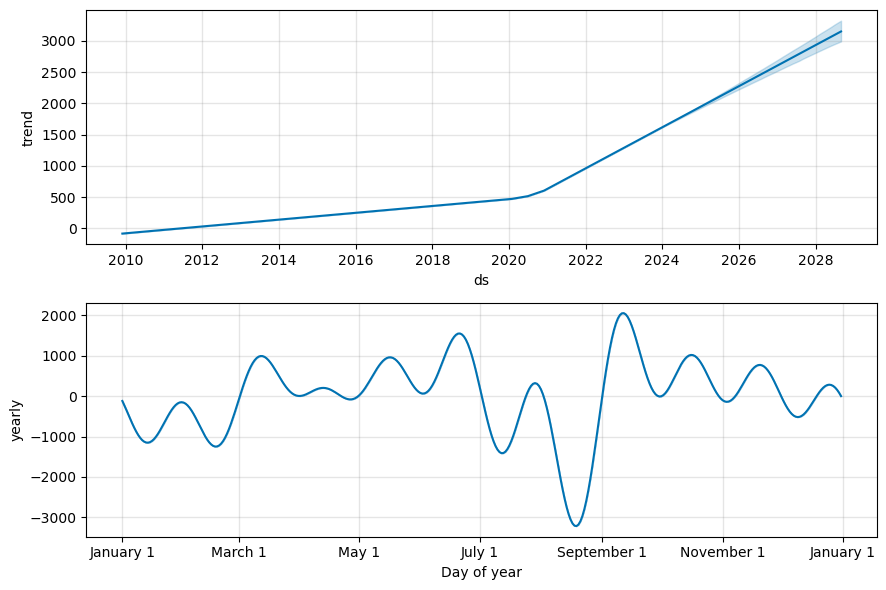

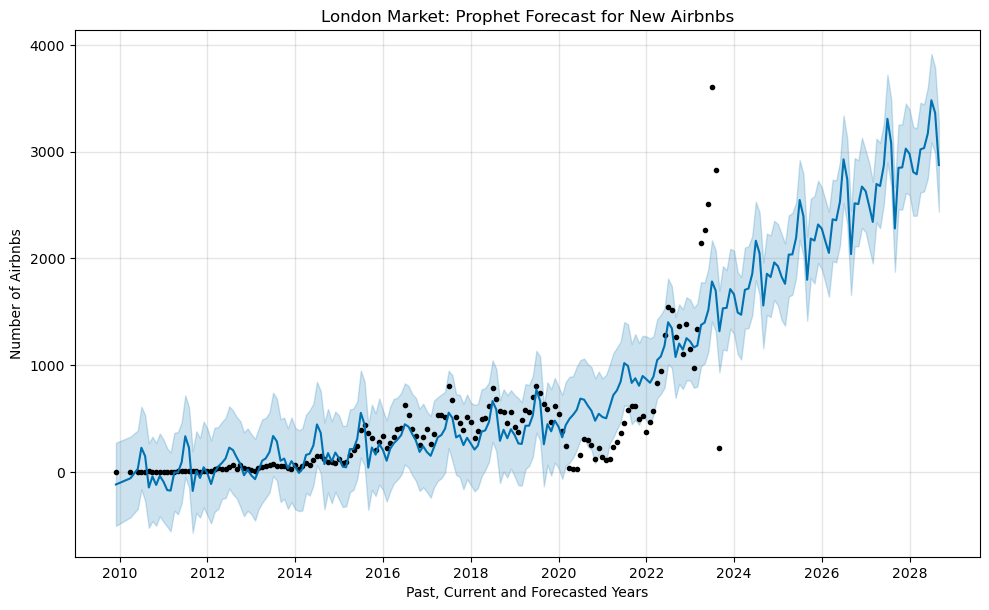

In [ ]:
#model and plot for new airbnbs
m = prophet.Prophet()
m.fit(new_bnb_df)
future_df = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future_df)
m.plot_components(forecast)

fig=m.plot(forecast)
plt.title("London Market: Prophet Forecast for New Airbnbs")
plt.xlabel("Past, Current and Forecasted Years")
plt.ylabel("Number of Airbnbs")
plt.show()

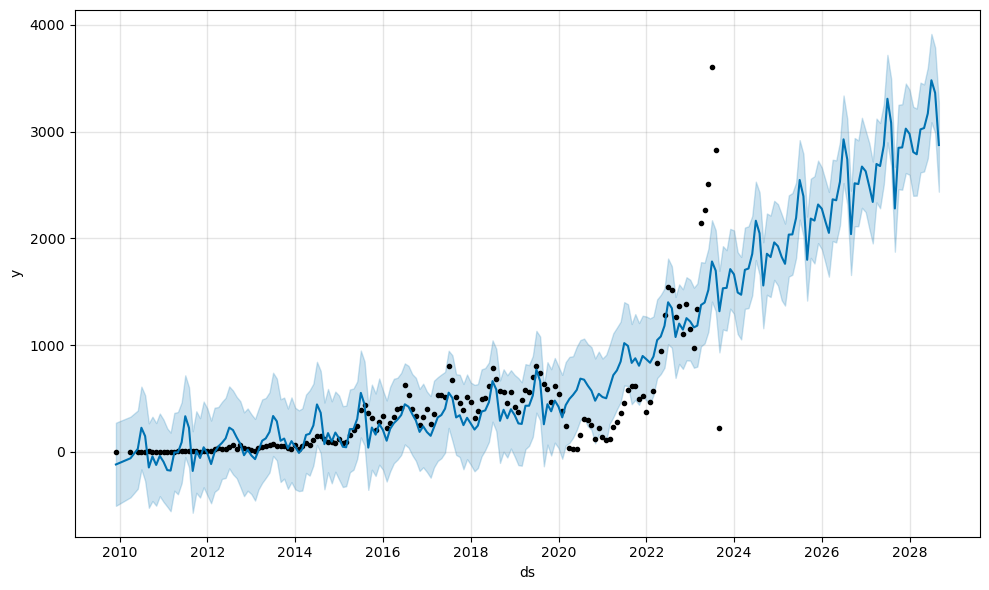

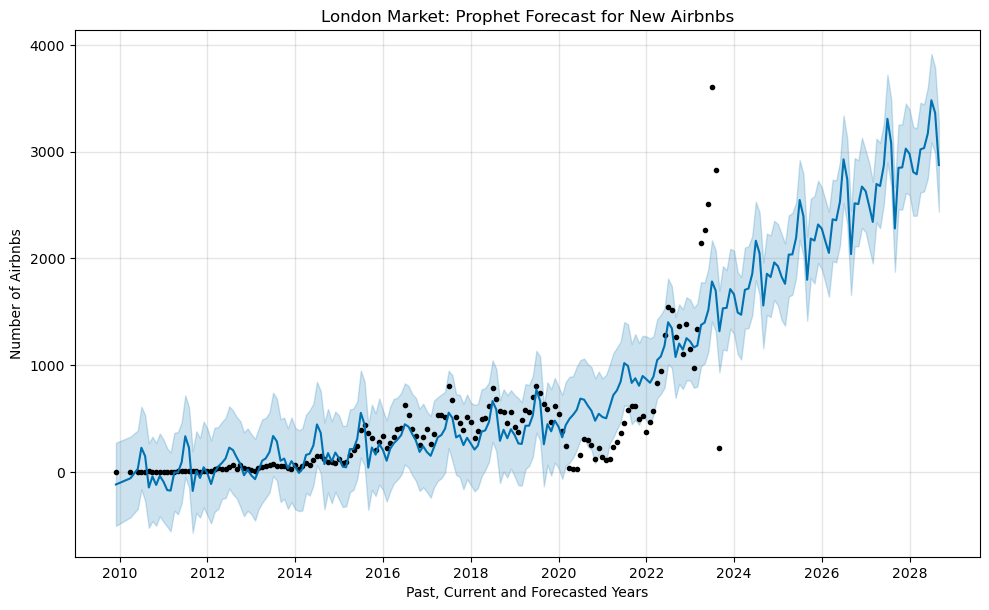

In [ ]:
m.plot(forecast)
fig=m.plot(forecast)
plt.title("London Market: Prophet Forecast for New Airbnbs")
plt.xlabel("Past, Current and Forecasted Years")
plt.ylabel("Number of Airbnbs")
plt.show()

18:54:15 - cmdstanpy - INFO - Chain [1] start processing


18:54:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this

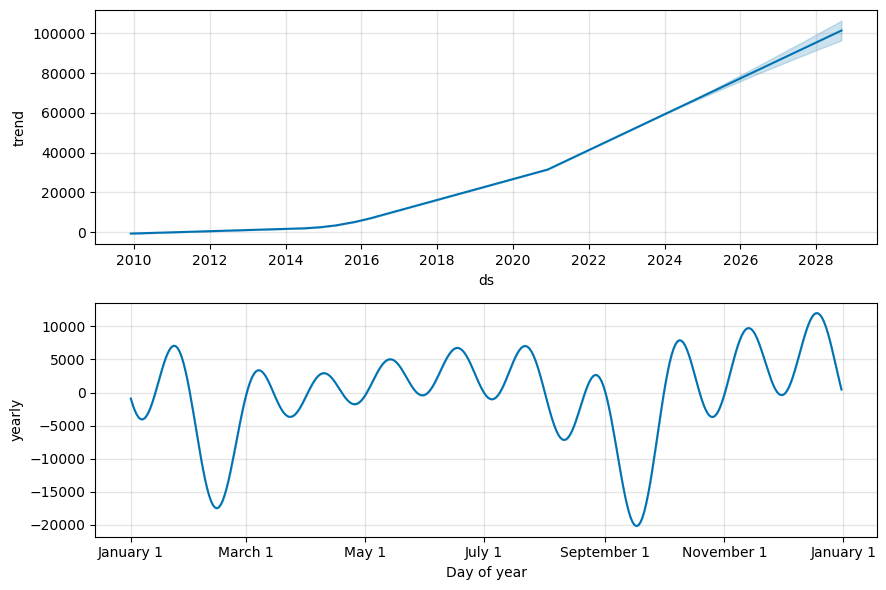

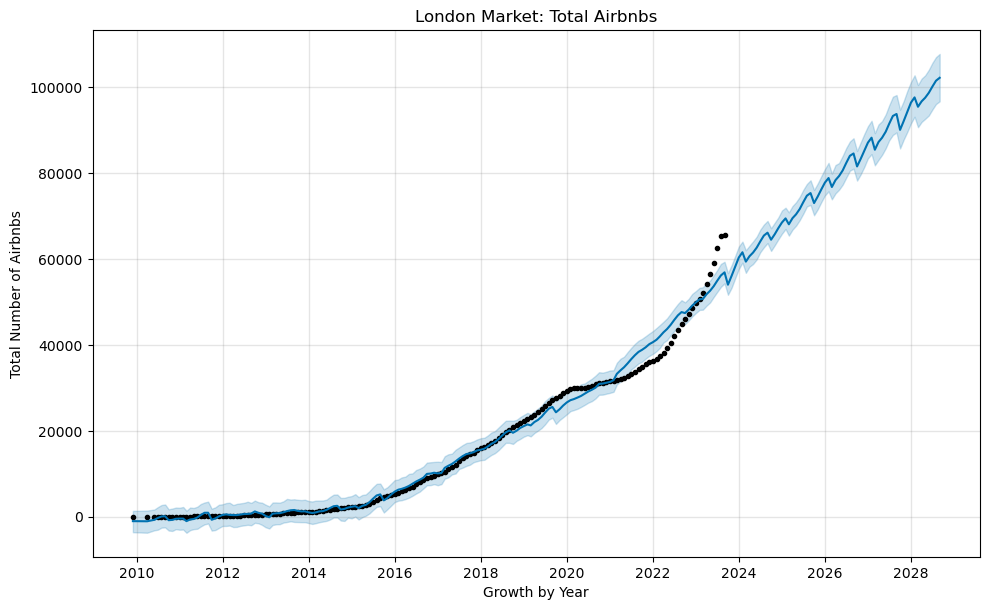

In [ ]:
#model and plot for total airbnbs
m2 = prophet.Prophet()
m2.fit(total_bnb_df)
future_df2 = m2.make_future_dataframe(periods=60, freq='M')
forecast2 = m2.predict(future_df2)
m2.plot_components(forecast2)
fig=m2.plot(forecast2)
plt.title("London Market: Total Airbnbs")
plt.xlabel("Growth by Year")
plt.ylabel("Total Number of Airbnbs")
plt.show()

# Visualizations

### Reviews with respect to the number of starbucks within 0.5 miles (distance may change based on group-by line)

SB_within_0.5_miles
0     34121
1     12838
2      6845
3      4217
4      2161
5      1649
6       902
7       672
8       429
9       530
10      444
11      276
12      158
13      219
14      104
15       84
16       13
Name: review_scores_rating, dtype: int64

<Axes: xlabel='SB_within_0.5_miles'>

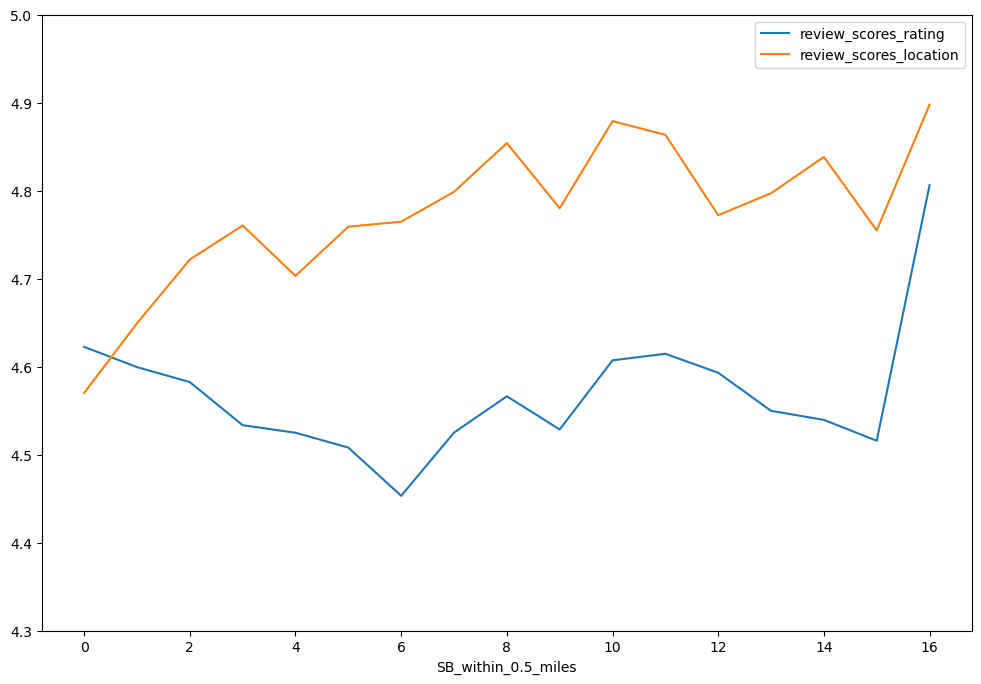

In [ ]:
#Aggregate reviews by the number of SB within X miles
airbnb_df_reviewed_only = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1]
aggregate_bnb_df = airbnb_df_reviewed_only.groupby(by=['SB_within_0.5_miles'])
agg_bnb_df_mean = aggregate_bnb_df[['price', 'review_scores_rating','review_scores_location']].mean()
display(aggregate_bnb_df['review_scores_rating'].count())
agg_bnb_df_mean[['review_scores_rating','review_scores_location']].plot(figsize=(12,8), ylim=(4.3,5))

### Not very helpful scatter-plot of reviews vs average distance to nearest 5 SB

<Axes: xlabel='nearest_5_avg', ylabel='review_scores_rating'>

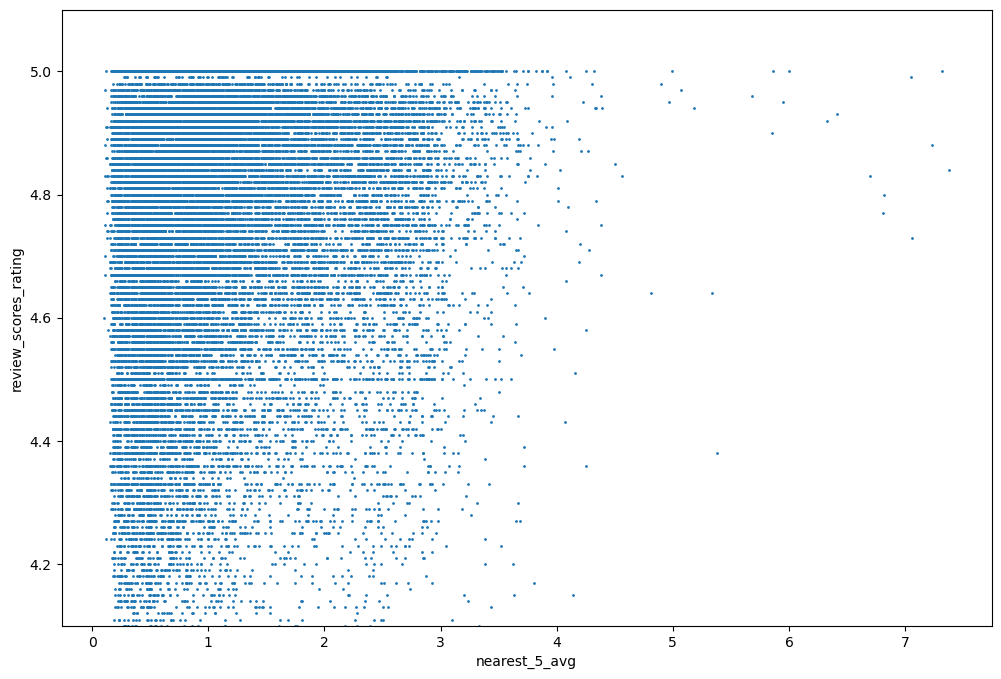

In [ ]:
airbnb_df.loc[(airbnb_df['review_scores_rating'] != -1) & (airbnb_df['number_of_reviews'] > 10)]\
    .plot(x='nearest_5_avg', y='review_scores_rating', kind='scatter', ylim=(4.1, 5.1), figsize=(12,8), s=1)

### Chart Depicting Reviews vs mileage to the nearest 5 starbucks

/var/folders/rp/ncflq_412jl43pyy15l7scc40000gn/T/ipykernel_48040/3287115838.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_near5_airbnb = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1].groupby('nearest_5_distance_bins')


Text(0.5, 1.0, 'London: Airbnb Reviews by Starbucks Location')

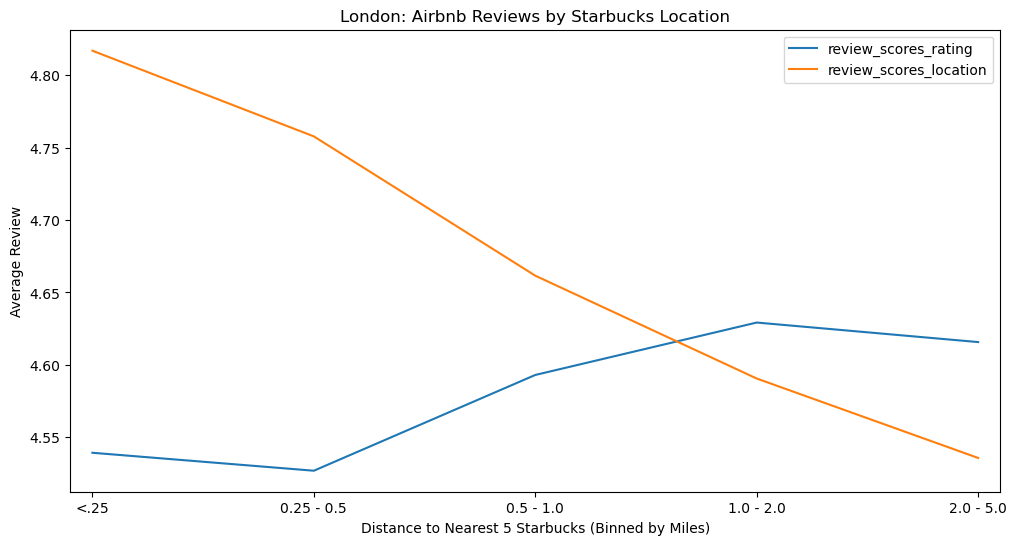

In [ ]:
#actual binning of the data by nearest_5_avg
nearest_5_bins = [0, 0.25, 0.5, 1, 2, 5]
labels = [1,2,3,4,5]
airbnb_df['nearest_5_distance_bins']=pd.cut(airbnb_df['nearest_5_avg'], bins=nearest_5_bins, labels=labels)
grouped_near5_airbnb = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1].groupby('nearest_5_distance_bins')
plt = grouped_near5_airbnb[['review_scores_rating', 'review_scores_location']].mean().plot(figsize=(12,6))
plt.set_xticks([0,1,2,3,4])
plt.set_xlim((-.1,4.1))
plt.set_xticklabels(['<.25','0.25 - 0.5','0.5 - 1.0','1.0 - 2.0','2.0 - 5.0'])
plt.set_xlabel("Distance to Nearest 5 Starbucks (Binned by Miles)")
plt.set_ylabel("Average Review")
plt.set_title("London: Airbnb Reviews by Starbucks Location")

### Average Price with respect to distance to nearest 5 starbucks (same bins as above)

Text(0.5, 1.0, 'London: Price Per Occupant Versus Proximity to Starbucks')

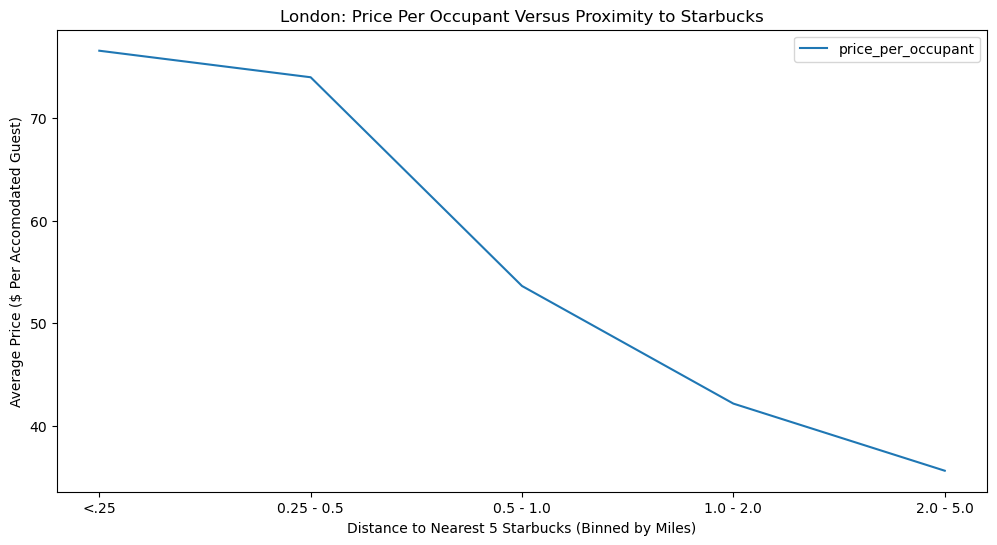

In [ ]:
plt2 = grouped_near5_airbnb[['price_per_occupant']].mean().plot(figsize=(12,6))
plt2.set_xticks([0,1,2,3,4])
plt2.set_xticklabels(['<.25','0.25 - 0.5','0.5 - 1.0','1.0 - 2.0','2.0 - 5.0'])
plt2.set_xlabel("Distance to Nearest 5 Starbucks (Binned by Miles)")
plt2.set_ylabel("Average Price ($ Per Accomodated Guest)")
plt2.set_title("London: Price Per Occupant Versus Proximity to Starbucks")

# Testing that supported decisions while writing

In [ ]:
#speed testing list comprehension vs. numpy eval:
def numpy_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    numpy_array = np.array(data_list)
    nearby_distances = numpy_array[numpy_array < 1]
    nearby_distances = np.sort(nearby_distances)
    nearby_count = len(nearby_distances)
    return(nearby_count,nearby_distances)

time_taken_numpy = timeit.timeit(numpy_speed, number=5000)

def list_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    keep_list = [x for x in data_list if x < 1]
    keep_list.sort()
    nearby_count = len(keep_list)
    return(nearby_count,keep_list)

time_taken_list = timeit.timeit(list_speed, number=1000)

print(f"numpy: {time_taken_numpy}")
print(f"list comprehension: {time_taken_list}")

#list comprehension was consistently ~5-10% faster

numpy: 9.119306958978996
list comprehension: 1.2251781249651685


In [ ]:
#Prepping Data into lat and long bins for geographical plotting
pydeck_df = airbnb_df[['latitude','longitude']].copy()
lat_min = pydeck_df['latitude'].min()
lat_max = pydeck_df['latitude'].max()
long_min = pydeck_df['longitude'].min()
long_max = pydeck_df['longitude'].max()
bin_count = 30

#Generate Bin Limits
lat_step = round((lat_max-lat_min)/bin_count,3)
long_step = round((long_max-long_min)/bin_count,3)
lat_bins = np.arange(lat_min,lat_max,lat_step)
long_bins = np.arange(long_min,long_max,long_step)

#The following solves some rounding errors that didn't bin data
lat_bins[0] -= .01
lat_bins[-1] += .01
long_bins[0] -= .01
long_bins[-1] += .01

#Generate Grid Centers
lat_centers = []
for index, item in enumerate(lat_bins):
    try:
        coord_center = (lat_bins[index] + lat_bins[index+1])/2
        lat_centers.append(coord_center)
    except IndexError:
        pass

long_centers = []
for index, item in enumerate(lat_bins):
    try:
        coord_center = (long_bins[index] + long_bins[index+1])/2
        long_centers.append(coord_center)
    except IndexError:
        pass
#Populate bins
pydeck_df['lat_bins'] = pd.cut(pydeck_df['latitude'], bins=lat_bins, labels=range(len(lat_bins)-1))
pydeck_df['long_bins'] = pd.cut(pydeck_df['longitude'], bins=long_bins, labels=range(len(long_bins)-1))

#Generate Pixels
pixel_pairs = []
for latitude in lat_centers:
    for longitude in long_centers:
        pair = [latitude, longitude]
        pixel_pairs.append(pair)

index_pairs = []
for x in range(len(lat_centers)):
    for y in range(len(long_centers)):
        pair = [x,y]
        index_pairs.append(pair)
pydeck_summary_df = pd.DataFrame({'xy_pair':index_pairs,'latlong_pair':pixel_pairs})
def pixel_counter(row):
    bin = row['xy_pair']
    count = len(pydeck_df.loc[(pydeck_df['lat_bins'] == bin[0]) & (pydeck_df['long_bins'] == bin[1])])
    return count

pydeck_summary_df['AirBnb_Count'] = pydeck_summary_df.apply(pixel_counter, axis=1)
pydeck_summary_df['lat'] = pydeck_summary_df['latlong_pair'].apply(lambda x: x[0] if x else None)
pydeck_summary_df['long'] = pydeck_summary_df['latlong_pair'].apply(lambda x: x[1] if x else None)
pydeck_summary_df = pydeck_summary_df.loc[pydeck_summary_df['AirBnb_Count'] > 0 ]

In [ ]:
pydeck_summary_df

,xy_pair,latlong_pair,AirBnb_Count,lat,long
13,"[0, 13]","[51.297437, -0.1467999999999997]",1,51.297437,-0.1468
14,"[0, 14]","[51.297437, -0.12079999999999969]",5,51.297437,-0.1208
20,"[0, 20]","[51.297437, 0.03520000000000045]",2,51.297437,0.0352
21,"[0, 21]","[51.297437, 0.061200000000000476]",5,51.297437,0.0612
22,"[0, 22]","[51.297437, 0.0872000000000005]",1,51.297437,0.0872
...,...,...,...,...,...
852,"[28, 12]","[51.67143699999995, -0.17279999999999973]",5,51.671437,-0.1728
855,"[28, 15]","[51.67143699999995, -0.09479999999999966]",15,51.671437,-0.0948
856,"[28, 16]","[51.67143699999995, -0.06879999999999964]",19,51.671437,-0.0688
857,"[28, 17]","[51.67143699999995, -0.042799999999999616]",45,51.671437,-0.0428


In [ ]:
#speed testing list comprehension vs. numpy eval:
def numpy_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    numpy_array = np.array(data_list)
    nearby_distances = numpy_array[numpy_array < 1]
    nearby_distances = np.sort(nearby_distances)
    nearby_count = len(nearby_distances)
    return(nearby_count,nearby_distances)

time_taken_numpy = timeit.timeit(numpy_speed, number=5000)

def list_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    keep_list = [x for x in data_list if x < 1]
    keep_list.sort()
    nearby_count = len(keep_list)
    return(nearby_count,keep_list)

time_taken_list = timeit.timeit(list_speed, number=1000)

print(f"numpy: {time_taken_numpy}")
print(f"list comprehension: {time_taken_list}")

#list comprehension was consistently ~5-10% faster

numpy: 9.124115249956958
list comprehension: 1.2266667500371113


In [ ]:
#Learning how to use pydeck
# Build the map layer:    
airbnbs = pdk.Layer(type='ColumnLayer',
                  data=pydeck_summary_df,
                  opacity=0.3 ,
                  get_position=['long','lat'],
                  get_elevation='AirBnb_Count',
                  auto_highlight=True,
                  elevation_scale=2,
                  pickable=True,
                  get_fill_color=['AirBnb_Count', 130],
                  coverage=12/(bin_count))

recommended_locations = [] #example  [[13,10],[15,7],[8,9]]
airbnbs_recommended = pdk.Layer(type='ColumnLayer',
                  data=pydeck_summary_df.loc[pydeck_summary_df['xy_pair'].isin(recommended_locations)],
                  opacity=1 ,
                  get_position=['long','lat'],
                  get_elevation=100,
                  auto_highlight=True,
                  elevation_scale=15,
                  pickable=True,
                  get_fill_color=[255,0,0,255],
                  coverage=4/(bin_count))

starbucks = pdk.Layer(
    "HeatmapLayer",
    data=starbucks_df,
    opacity=0.8,
    get_position=["longitude", "latitude"],
    threshold=0.75,
    aggregation=pdk.types.String("SUM"),
    get_weight=4,
    pickable=True,
)

# Set the view parameters:
view_state = pdk.ViewState(longitude=pydeck_summary_df['long'].mean(), 
                           latitude=pydeck_summary_df['lat'].mean(),
                           zoom=10,
                           min_zoom=9,
                           max_zoom=16,
                           pitch=45.0,
                           bearing=30)

# Render the map:
r = pdk.Deck(layers=[airbnbs, starbucks], initial_view_state=view_state, map_style=pdk.map_styles.DARK)
r.to_html('london_airbnb.html')
clear_output(wait=False)

In [ ]:
import zipfile
import os

In [ ]:
# File paths
file_to_zip = './london_airbnb.html'
zip_file_name = 'london_map.zip'

# Create a new zip file
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(file_to_zip, arcname='file.txt')

print("File zipped successfully")
#File is ignored, so no need to delete, but an option
# os.remove('london_airbnb.html')


File zipped successfully
